In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import log_loss
from utilities import *

<frozen importlib._bootstrap>:228: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


In [37]:
data = pd.read_csv('compas.csv', usecols=['Age=18-20', 'Race=African-American', 'Prior-Crimes=0','Gender=Male', 'Juvenile-Crimes=0', 'Current-Charge-Degree=Misdemeanor'])
X = data.rename({'Age=18-20':"age", 'Race=African-American':"race", 'Prior-Crimes=0':"prior", 'Gender=Male':"gender", 'Juvenile-Crimes=0':"juvenilecrime", 'Current-Charge-Degree=Misdemeanor':"currentcharge"}, axis='columns')
y = pd.read_csv('compas.csv', usecols=['Recidivate-Within-Two-Years'])
# y[y==0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [71]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train, y_train)

beta_clf = np.zeros(7)
beta_clf[0] = clf.intercept_[0]
beta_clf[1:] = clf.coef_
beta_clf
# clf.score(X_test, y_test)

array([ 0.58907879,  1.36575695,  0.33650497,  0.35032477, -0.95140773,
       -0.80508858, -0.23811409])

In [72]:
def loss_classification(y_pred, y_true):
    print(y_pred, y_true)
    return np.sum(np.log(1 + np.exp(-np.multiply(y_true, y_pred))))

def find_boundary(y_true, y_pred, epsilon=0.05, regression=True):
    # the optimal loss and boundary
    if regression:
        loss0 = loss_regression(y_true, y_pred)
    else:
        loss0 = loss_classification(y_true, y_pred)

    # Given epsilon, find boundary and half boundary
    epsilon = 0.05
    bound_f = loss0*epsilon
    bound_f_half = loss0*epsilon*0.5
    
    return loss0, bound_f, bound_f_half


In [79]:
import statsmodels.api as sm

# parameter
epsilon = 0.05
NUM = 500 # number of points in each round of sampling
NUM_PCA = 5
size = 10 # for initial sampling
epsScale = 1.5 # over-sample a bit
vlist = ["age", "race", "prior", "gender", "juvenilecrime", "currentcharge"]
# vlist = ["age", "race", "prior", "gender"]


model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
beta = model.params
se = model.bse

Optimization terminated successfully.
         Current function value: 0.640419
         Iterations 6


In [74]:
y = y.to_numpy().reshape(len(y))
y_test = y_test.to_numpy().reshape(len(y_test))
y_train = y_train.to_numpy().reshape(len(y_train))

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [75]:
loss0, bound_f, bound_f_half = find_boundary(clf.predict(X_test), y_test, regression=False)
print(loss0, bound_f, bound_f_half)

[0 0 0 ... 0 0 1] [0 1 1 ... 0 0 0]
8.573744361643135e+02 42.868721808215675 21.434360904107837


In [34]:
def loss_classification(y_pred, y_true):
    return np.sum(np.log(1 + np.exp(-np.multiply(y_true, y_pred))))

X0 = X_train.copy()
print(X0['age'])
X0['age'] = X0['age']*(1.08)
print(X0['age'])

loss_classification(clf.predict(X0), y_train)

756     0
5623    0
6997    1
2442    0
3913    0
       ..
2139    0
3779    0
6774    0
4488    0
864     0
Name: age, Length: 5771, dtype: int64
756     0.00
5623    0.00
6997    1.08
2442    0.00
3913    0.00
        ... 
2139    0.00
3779    0.00
6774    0.00
4488    0.00
864     0.00
Name: age, Length: 5771, dtype: float64


3.982833198667663e+03

In [37]:
def explore_R(vname, bound, loss0, model, X, y, delta=0.1, direction=True, regression=True):
    '''

    Explore the Rashomon set by find the boundary for single variable in variable 
    list in two directions from range [0,1]
        Input:
            vname: variable name list of length n
            bound: loss boundary in R set
            model: optimal model
            X, y: model input and expected output
            delta: the range of spliting 0 to 1
            direction: exploring directions. When True, explore from 1 to 1+, else 1 to 1-

        Output:
            vt_all: variance tolerance for all features in a nx2 matrix
            points_all: recorded points when exploring

    '''
    vt_all = []
    points_all = []
    
    loss_temp = 0
#     count the tolerance
    loss_count = 0

    for i in np.arange(0.1, 1+0.1, delta):
        # include endpoint [0.1 ..., 1]
        count = 1
        # learning rate         
        lr = 0.1
        points = []
#         variance tolerance for single feature
        vt = 1
#     termination condition: the precision of vt .0001
        while count <= 4:
    #         input new input X0 and calculate the loss
            X0 = X.copy()
            if direction:
                X0[vname] = X0[vname]*(vt+lr)
            if not direction:
                X0[vname] = X0[vname]*(vt-lr)
    #         myloss_user = totalloss(beta_lr, X0, y)
            pred = model.predict(X0)
            if regression:
                myloss=loss_regression(pred, y)
            else:
                myloss=loss_classification(pred, y)
#             the diffrence of changed loss and optimal loss
            mydiff = abs(myloss-loss0)
            print(myloss-loss0)
            if mydiff<i*bound:
                if direction:
                #     if the loss within the bound, then vt increses
                    vt=vt+lr
                if not direction:
                    vt = vt-lr
                points.append([vt, mydiff])
    #             if the loss within the bound but stays same for loss_count times, then the vt is unimportant.
                if loss_temp == myloss:
                    loss_count = loss_count+1
                    if loss_count > 1000:
                        break
                else:
                    loss_temp = myloss
    #                 otherwise change lr and try again
            else:
                lr=lr*0.1
                count = count+1
        points_all.append(points)
        vt_all.append(vt)
    return vt_all, points_all


def find_VT(bound, loss0, vlist, model, X, y, delta=0.1, regression=True):
    '''
    find R set of variable list for the black box model in data set (X, y) of a boundary
    
        Input:
            bound: boundary of R set
            vlist: variable list of length n
            model: optimal model
            X,y: data set
            delta: the range of spliting 0 to 1, d=1/delta
        Output:
            VT: variance tolerance for all features in range, nxdx2
            points_all_max, points_all_min: recorded training process
    
    '''
    n = len(vlist)
    d = len(np.arange(0.1, 1+0.1, delta))
    VT = np.zeros([n, d, 2])
    points_all_max = []
    points_all_min = []

    for idx, vname in enumerate(vlist):
        vt_plus, points_max = explore_R(vname, bound, loss0, model, X, y, direction=True, delta=0.1, regression=regression)
        points_all_max.append(points_max)
        vt_minus, points_min = explore_R(vname, bound, loss0, model, X, y, direction=False, delta=0.1, regression=regression)
        points_all_min.append(points_min)
        VT[idx,:,0] = vt_plus
        VT[idx,:,1] = vt_minus
    return VT, points_all_max, points_all_min

In [ ]:
points_all = [np.array(points_all_min)[:,0][i]+np.array(points_all_max)[:,0][i] for i in range(len(points_all_min))]

for i in points_all:
    i=np.array(i)
    plt.plot(i[:,0],i[:,1], '-o')


In [57]:
# user defined loss
def totalloss(beta, X, y):
    loss = np.sum(np.log(1 + np.exp(-(y * (np.matmul(X, beta[1:]) + beta[0])))))
    return loss

def modelreliance(vname, beta, X, y):
    X_interest = X.loc[(X[vname] == 1)]
    p = X_interest.shape[0]/X.shape[0]
    X0 = X.copy()
    # replaced by 1 with prob p
    X0[vname] = 1
    loss = totalloss(beta, np.array(X0), np.array(y)) * p
    X0[vname] = 0
    loss = loss + totalloss(beta, np.array(X0), np.array(y)) * (1-p) # this is the loss after shuffle the obs
    mr = loss/totalloss(beta, np.array(X), np.array(y))
    return mr


def modelreliance_full(vlist, beta, X, y):
    mr = np.zeros(len(vlist))
    i = 0
    for vname in vlist:
        mr[i] = modelreliance(vname, beta, X, y)
        i = i+1
    return mr


In [7]:
beta_user = [0.5435, 1.4684, 0.3522, -0.8665, 0.3208, -0.8816, -0.2340]
se_user = [0.1227, 0.2171, 0.0600, 0.0686, 0.0761, 0.0971, 0.0631]

In [77]:
# ml = modelreliance_full(vlist, beta, X_test, y_test)
loss0 = totalloss(beta_clf, X_test, y_test)
bound = loss0*(1+epsilon*0.5)
print(loss0, bound)


9.807603064290388e+02 1005.2793140897646


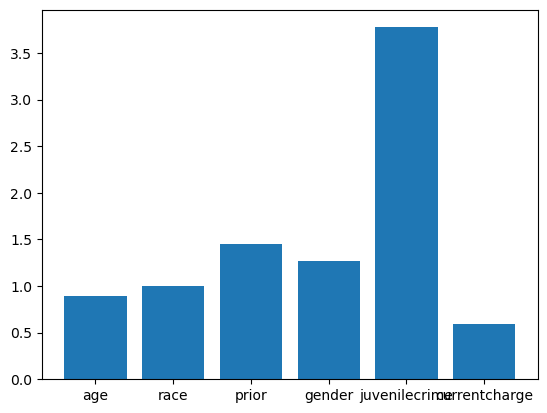

In [93]:
import matplotlib.pyplot as plt
plt.bar((vlist), (1/(vt_f[:,0]-vt_f[:,1])))
# plt.xticks(range(len(model.feature_importances_)), train_features.columns)
plt.show()

In [9]:
# initial sampling points
points = np.random.uniform(low=-1, high=1, size=[NUM, len(beta)])
points = np.matmul(points, np.diag(size*se))
points = points + np.array(beta)

myLoss = np.zeros(len(points))
for i in range(len(points)):
    myLoss[i] = totalloss(points[i,],X_train, y_train)
# keep good models only
points = points[myLoss < bound]

NameError: name 'beta' is not defined

In [24]:
def ellipsoid(cen, ln, rot, NUM):
    # sampling points
    points = np.random.uniform(low=-1, high=1, size=[NUM, len(cen)])
    r = np.sqrt(np.sum(np.square(points), axis=0))
    points = np.matmul(points, np.diag(1/r))
    r = np.random.beta(2,1,NUM)

    # get points from p-sphere
    points = np.matmul(np.diag(r), points)

    # stretch, rotate and shift to get ellipsoid
    points = np.matmul(points, np.diag(ln))
    points = np.matmul(points, np.transpose(rot))
    points = points + cen

    return points

In [15]:
from sklearn.decomposition import PCA

for i in range(NUM_PCA):
    pca = PCA()
    pca.fit(points)
    cen = pca.mean_
    ln = np.max(abs(pca.components_), axis=1) * epsScale
    rot = pca.components_.T * np.sqrt(pca.explained_variance_)
    # next round of samping
    points = ellipsoid(cen, ln, rot, NUM)
    myLoss = np.zeros(len(points))
    for i in range(len(points)):
        myLoss[i] = totalloss(points[i,],X_train, y_train)
    # keep good models only
    points = points[myLoss < bound]
    

NameError: name 'points' is not defined

In [7]:
def find_boundary(y_true, y_pred, epsilon=0.05):
    # the optimal loss and boundary
    loss0 = log_loss(y_true, y_pred)

    # Given epsilon, find boundary and half boundary
    epsilon = 0.05
    bound_f = loss0*epsilon
    bound_f_half = loss0*epsilon*0.5
    
    return loss0, bound_f, bound_f_half

def explore_R(vname, bound, loss0, model, X, y, delta=0.1, direction=True):
    '''

    Explore the Rashomon set by find the boundary for single variable in variable 
    list in two directions from range [0,1]
        Input:
            vname: variable name list of length n
            bound: loss boundary in R set
            model: optimal model
            X, y: model input and expected output
            delta: the range of spliting 0 to 1
            direction: exploring directions. When True, explore from 1 to 1+, else 1 to 1-

        Output:
            vt_all: variance tolerance for all features in a nx2 matrix
            points_all: recorded points when exploring

    '''
    vt_all = []
    points_all = []
    
    loss_temp = 0
#     count the tolerance
    loss_count = 0

    for i in np.arange(0.1, 1+0.1, delta):
        # include endpoint [0.1 ..., 1]
        count = 1
        # learning rate         
        lr = 0.1
        points = []
#         variance tolerance for single feature
        vt = 1
#     termination condition: the precision of vt .0001
        while count <= 4:
    #         input new input X0 and calculate the loss
            X0 = X.copy()
            if direction:
                X0[vname] = X0[vname]*(vt+lr)
            if not direction:
                X0[vname] = X0[vname]*(vt-lr)
    #         myloss_user = totalloss(beta_lr, X0, y)
            pred = model.predict(X0)
            myloss=log_loss(y, pred)
#             the diffrence of changed loss and optimal loss
            mydiff = myloss-loss0
            if mydiff<i*bound:
                if direction:
                #     if the loss within the bound, then vt increses
                    vt=vt+lr
                if not direction:
                    vt = vt-lr
                points.append([vt, mydiff])
    #             if the loss within the bound but stays same for loss_count times, then the vt is unimportant.
                if loss_temp == myloss:
                    loss_count = loss_count+1
                    if loss_count > 10000:
                        break
                else:
                    loss_temp = myloss
    #                 otherwise change lr and try again
            else:
                lr=lr*0.1
                count = count+1
        points_all.append(points)
        vt_all.append(vt)
    return vt_all, points_all


def find_VT(bound, loss0, vlist, model, X, y, delta=0.1):
    '''
    find R set of variable list for the black box model in data set (X, y) of a boundary
    
        Input:
            bound: boundary of R set
            vlist: variable list of length n
            model: optimal model
            X,y: data set
            delta: the range of spliting 0 to 1, d=1/delta
        Output:
            VT: variance tolerance for all features in range, nxdx2
            points_all_max, points_all_min: recorded training process
    
    '''
    n = len(vlist)
    d = len(np.arange(0.1, 1+0.1, delta))
    VT = np.zeros([n, d, 2])
    points_all_max = []
    points_all_min = []

    for idx, vname in enumerate(vlist):
        vt_plus, points_max = explore_R(vname, bound, loss0, model, X, y, direction=True, delta=0.1)
        points_all_max.append(points_max)
        vt_minus, points_min = explore_R(vname, bound, loss0, model, X, y, direction=False, delta=0.1)
        points_all_min.append(points_min)
        VT[idx,:,0] = vt_plus
        VT[idx,:,1] = vt_minus
    return VT, points_all_max, points_all_min

In [23]:
points

array([[ 0.92849927,  1.60726867,  0.4724336 , ..., -0.73679556,
        -0.83201601, -0.14897328],
       [ 0.92849925,  1.60726859,  0.47243359, ..., -0.73679555,
        -0.83201599, -0.14897329],
       [ 0.92849926,  1.60726837,  0.47243363, ..., -0.73679554,
        -0.83201602, -0.14897331],
       ...,
       [ 0.92849932,  1.60726854,  0.47243361, ..., -0.7367956 ,
        -0.832016  , -0.1489733 ],
       [ 0.92849927,  1.60726864,  0.47243361, ..., -0.73679558,
        -0.832016  , -0.14897328],
       [ 0.92849919,  1.60726923,  0.47243355, ..., -0.73679551,
        -0.832016  , -0.14897325]])

In [28]:
vt_f

array([[[ 1.1200e+01,  3.5960e-01],
        [ 1.1000e+00,  1.4200e-02],
        [ 1.1000e+00, -6.0040e-01],
        [ 1.1000e+00, -8.3410e-01],
        [ 1.1000e+00, -8.3410e-01],
        [ 1.1000e+00, -4.3000e+00],
        [ 1.1000e+00,  8.0000e-01],
        [ 1.1000e+00,  9.0000e-01],
        [ 1.1000e+00,  9.0000e-01],
        [ 1.1000e+00,  9.0000e-01]],

       [[ 1.0604e+00, -7.8000e-03],
        [ 2.5382e+00, -2.3100e-02],
        [ 2.5382e+00, -2.3100e-02],
        [ 2.5382e+00, -2.3100e-02],
        [ 2.5100e+00, -2.3100e-02],
        [ 1.2000e+00, -2.3100e-02],
        [ 1.1000e+00, -2.3100e-02],
        [ 1.1000e+00,  8.0000e-01],
        [ 1.1000e+00,  9.0000e-01],
        [ 1.1000e+00,  9.0000e-01]],

       [[ 1.3934e+00,  3.9950e-01],
        [ 2.0699e+00,  3.9950e-01],
        [ 7.6000e+00,  3.9950e-01],
        [ 1.2000e+00,  3.9950e-01],
        [ 1.1000e+00,  2.0770e-01],
        [ 1.1000e+00,  2.0770e-01],
        [ 1.1000e+00,  2.0770e-01],
        [ 1.1000e+00,  4

In [16]:
mcr = np.zeros([len(points), len(vlist)])

In [24]:
vt_f

array([[[ 1.0012e+03,  1.0000e+00],
        [ 1.1000e+00,  1.0000e+00],
        [ 1.1000e+00,  1.0000e+00],
        [ 1.1000e+00, -1.0000e+00],
        [ 1.1000e+00, -1.0000e+00],
        [ 1.1000e+00, -1.0000e+00],
        [ 1.1000e+00, -1.0000e+00],
        [ 1.1000e+00, -1.0000e+00],
        [ 1.1000e+00, -1.0000e+00],
        [ 1.1000e+00, -9.8730e+02]],

       [[ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00]],

       [[ 2.0000e+00, -1.0000e+00],
        [ 2.0000e+00, -1.0000e+00],
        [ 3.0000e+00, -1.0000e+00],
        [ 3.0000e+00, -1.0000e+00],
        [ 3.0000e+00, -1.0000e+00],
        [ 3.0000e+00, -1.0000e+00],
        [ 3.0000e+00, -1.0000e+00],
        [ 3.0000e+00, -1

In [28]:
vt_f

array([[[ 1.0012e+03,  1.0000e+00],
        [ 1.1000e+00,  1.0000e+00],
        [ 1.1000e+00,  1.0000e+00],
        [ 1.1000e+00, -1.0000e+00],
        [ 1.1000e+00, -1.0000e+00],
        [ 1.1000e+00, -1.0000e+00],
        [ 1.1000e+00, -1.0000e+00],
        [ 1.1000e+00, -1.0000e+00],
        [ 1.1000e+00, -1.0000e+00],
        [ 1.1000e+00, -9.8730e+02]],

       [[ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00]],

       [[ 2.0000e+00, -1.0000e+00],
        [ 2.0000e+00, -1.0000e+00],
        [ 3.0000e+00, -1.0000e+00],
        [ 3.0000e+00, -1.0000e+00],
        [ 3.0000e+00, -1.0000e+00],
        [ 3.0000e+00, -1.0000e+00],
        [ 3.0000e+00, -1.0000e+00],
        [ 3.0000e+00, -1

In [17]:
for i in range(len(points)):
    mcr[i] = modelreliance_full(vlist, points[i], X_train, y_train)

In [18]:
mcr

array([[1.00576749, 1.00485978, 1.03226356, 1.00426547, 1.00741796,
        1.00087008],
       [1.00576749, 1.00485978, 1.03226356, 1.00426547, 1.00741796,
        1.00087008],
       [1.00576748, 1.00485978, 1.03226356, 1.00426547, 1.00741796,
        1.00087008],
       ...,
       [1.00576749, 1.00485978, 1.03226356, 1.00426547, 1.00741796,
        1.00087008],
       [1.00576748, 1.00485978, 1.03226356, 1.00426547, 1.00741796,
        1.00087008],
       [1.00576749, 1.00485978, 1.03226356, 1.00426547, 1.00741796,
        1.00087008]])

In [28]:
bound =log_loss(y_test, model.predict(sm.add_constant(X_test))) * (1+epsilon)
bound

0.671197332259657

In [15]:
VT

array([[ 3.2469, -0.6509],
       [ 2.4515, -0.5781],
       [ 1.902 ,  0.2142],
       [ 1.8741, -0.4485],
       [ 1.5845,  0.6428],
       [ 6.2784, -1.6615]])

In [106]:
bound_user = totalloss(beta_user, X_train, y_train)*(1+epsilon)
bound_user

3289.5512012621166

In [36]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)

In [37]:
model_minmax = sm.Logit(y_train, sm.add_constant(X_train_minmax)).fit()
beta_minmax = model_minmax.params
se_minmax = model_minmax.bse

Optimization terminated successfully.
         Current function value: 0.640067
         Iterations 6


In [73]:
modelreliance_full(vlist, beta, X_train, y_train)

array([1.01967126, 1.01058631, 1.05873232, 1.00753156, 1.0307241 ,
       1.0022914 ])

In [74]:
for i in range(len(vlist)):
    for j in range(2):
        X0 = X_train.copy()
        vn = vlist[i]
#         boundary model
        X0[vn] = X0[vn]*VT[i, j]
#     for all features, calculate mr
        for vname in vlist:
            print(j, vn, modelreliance(vname, beta, X0, y_train))

age
0 age 0.9610220342370659
0 age 1.0100664113451816
0 age 1.0581337514362987
0 age 1.0074185054219225
0 age 1.0279206364160705
0 age 1.0020813107822413
age
1 age 0.9610245421114293
1 age 1.0106710355005544
1 age 1.0518278223822792
1 age 1.0071508451781581
1 age 1.0375678255558156
1 age 1.0028195925602443
race
0 race 1.0187141257627952
0 race 0.9626368648585258
0 race 1.0491657058390949
0 race 1.0066587694355307
0 race 1.0264017364842712
0 race 1.0014292331637273
race
1 race 1.0187388962915949
1 race 0.9626355396022225
1 race 1.0635558708869164
1 race 1.0081211125173037
1 race 1.0341513308218693
1 race 1.0031219204503503
prior
0 prior 1.0213656840117817
0 prior 1.0071949665534334
0 prior 0.9913614788558291
0 prior 1.0055483596989871
0 prior 1.021083934360212
0 prior 1.0008731351724882
prior
1 prior 1.0165735738770096
1 prior 1.0139160669245921
1 prior 0.9913611002612011
1 prior 1.0093978662042278
1 prior 1.0384026252660725
1 prior 1.0040657694886443
gender
0 gender 1.019448595380877
0

In [58]:
points_all

[[[0.9, 0.0018475750577366945],
  [0.8, 0.0018475750577366945],
  [0.79, 0.0018475750577366945],
  [0.78, 0.0018475750577366945],
  [0.77, 0.0018475750577366945],
  [0.76, 0.0018475750577366945],
  [0.75, 0.0018475750577366945],
  [0.74, 0.0018475750577366945],
  [0.73, 0.0018475750577366945],
  [0.72, 0.003695150115473389],
  [0.71, 0.003695150115473389],
  [0.709, 0.003695150115473389],
  [0.7089, 0.003695150115473389],
  [0.7088, 0.003695150115473389],
  [0.7087, 0.003695150115473389],
  [0.7086, 0.003695150115473389],
  [0.7085, 0.003695150115473389],
  [0.7084, 0.003695150115473389],
  [0.7083, 0.003695150115473389],
  [0.7082, 0.003695150115473389],
  [0.7081000000000001, 0.003695150115473389],
  [1.1, 0.0],
  [1.2000000000000002, 0.0],
  [1.3000000000000003, 0.0],
  [1.4000000000000004, 0.0],
  [1.5000000000000004, 0.0],
  [1.6000000000000005, 0.0],
  [1.7000000000000006, 0.0],
  [1.8000000000000007, 0.0],
  [1.9000000000000008, 0.0],
  [2.000000000000001, 0.0],
  [2.10000000000

/tmp/ipykernel_3883343/3718344969.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  points_all = [np.array(p_min)[:][i]+np.array(p_max)[:][i] for i in range(len(p_min))]


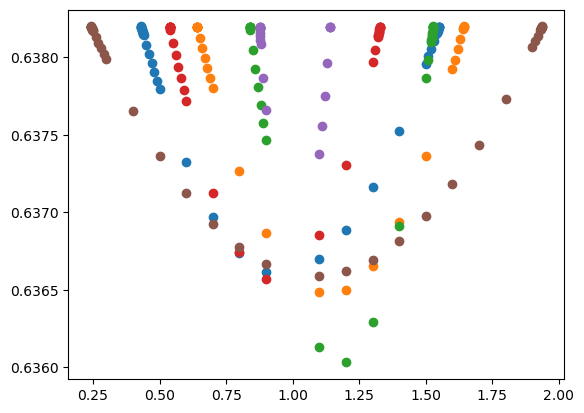

In [100]:
points_all = [np.array(p_min)[:][i]+np.array(p_max)[:][i] for i in range(len(p_min))]

for i in points_all:
    i=np.array(i)
    plt.scatter(i[:,0],i[:,1])


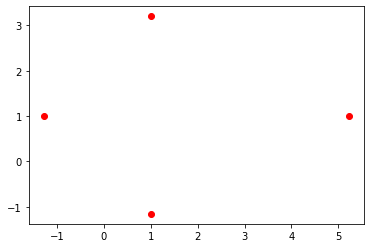

In [167]:
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt
import numpy as np

gg_xy=np.array([[-1.2767,1], [5.22,1],[1,3.2038],[1,-1.1584]
                ])
plt.plot(gg_xy[:,0],gg_xy[:,1],'ro')

plt.show()

In [21]:
from sklearn.inspection import plot_partial_dependence

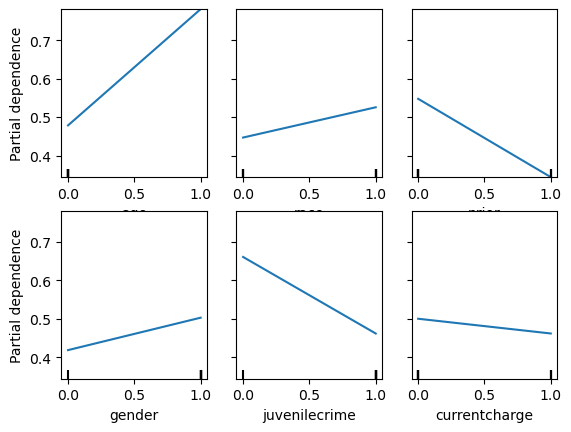

In [22]:
from sklearn.linear_model import LogisticRegression
plot_partial_dependence(clf, X_train, vlist)

In [23]:
from sklearn_gbmi import *

<frozen importlib._bootstrap>:228: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


In [40]:
pair_l = find_all_pairs(vlist)
h_FI = np.zeros((len(vlist), len(vlist)))
for pair in pair_l:
    FI = FI_two(pair[0], pair[-1])
    print(pair, FI)
    i=vlist.index(pair[0])
    j=vlist.index(pair[1])
#     h_FI[i,j] = np.sum([i**2 for i in FI])/((0.05*loss0)*(0.05*loss0))
#     h_FI[i,j] = abs(max(FI)-min(FI))/np.mean(FI)
    fi = abs(max(FI)-min(FI))
    h_FI[i,j] = np.square(fi-1)/np.square(fi)
h_FI

('age', 'race') [3.7877837931387376e+01, 29.316076333494493, 24.005329066373633, 46.861372065441174]
('age', 'prior') [2.49640875437085e+01, 39.74322324017635, 47.682171613020955, 22.248272927439757]
('age', 'gender') [3.754732174773858e+01, 27.89313581759461, 26.02973393326579, 49.355263006450514]
('age', 'juvenilecrime') [2.836516635442308e+01, 37.46702949740097, 44.67936706288606, 28.184742786381094]
('age', 'currentcharge') [3.030784217503674e+01, 36.040894876905895, 39.89368330216371, 31.672950410955536]
('race', 'prior') [1.2570319826588047e+01, 56.21279099849903, 54.14892791963439, 12.455298110138756]
('race', 'gender') [6.553141772311938e+01, -21.298505757436942, -2.4990983683724153, 95.90260492372317]
('race', 'juvenilecrime') [-2.1026611232938194e+01, 67.28217606789713, 92.04799277159486, -2.4106802395099294]
('race', 'currentcharge') [-2.233062884707124e+00, 52.86719699379978, 70.89076863516652, 14.035263535891318]
('prior', 'gender') [1.1300358530300855e+01, 66.229292309662

array([[0.        , 0.91441004, 0.92291066, 0.916095  , 0.88242386,
        0.80224172],
       [0.        , 0.        , 0.95481581, 0.98300812, 0.98239077,
        0.97283615],
       [0.        , 0.        , 0.        , 0.9712014 , 0.97561489,
        0.96783868],
       [0.        , 0.        , 0.        , 0.        , 0.986374  ,
        0.97918051],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.98044886],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [26]:
import itertools
from sklearn.inspection import partial_dependence

univariate = {}
for i in range(len(vlist)):
    univariate[i] = partial_dependence(clf, X_train, features=[i], kind='average')['average']
    
bivariate = {}
for i, j in itertools.combinations(range(len(vlist)),2):
    bivariate[(i, j)] = partial_dependence(clf, X_train, features=[i, j], kind='average')['average']



In [95]:
loss0 = log_loss(y_test, model.predict(sm.add_constant(X_test)))
bound = loss0*(1+epsilon*0.05)
print(bound)
vt_f, p_max, p_min = find_VT(bound)

6.381987558258162e-01
6.366983062827046e-01 1
6.368853307773403e-01 1.1
6.371618968099101e-01 1.2000000000000002
6.375215033828093e-01 1.3000000000000003
6.379576660054667e-01 1.4000000000000004
6.38464009568987e-01 1.5000000000000004
6.380052460074793e-01 1.5000000000000004
6.380535213721088e-01 1.5100000000000005
6.381024858303771e-01 1.5200000000000005
6.381521331339284e-01 1.5300000000000005
6.38202457055726e-01 1.5400000000000005
6.381571351808448e-01 1.5400000000000005
6.381621439877105e-01 1.5410000000000004
6.381671595483125e-01 1.5420000000000003
6.381721818564401e-01 1.5430000000000001
6.381772109058848e-01 1.544
6.381822466904404e-01 1.545
6.381872892039031e-01 1.5459999999999998
6.381923384400708e-01 1.5469999999999997
6.381973943927443e-01 1.5479999999999996
6.38202457055726e-01 1.5489999999999995
6.381979003571807e-01 1.5489999999999995
6.381984063887142e-01 1.5490999999999995
6.381989124873383e-01 1.5491999999999995
6.36484520082082e-01 1
6.364993218680737e-01 1.1
6.3665

In [90]:
def findMax(vname, bound):
    lr = 0.1
    vt = 1
    count = 1
    points = []
    while count <= 4:
        X0 = X_test.copy()
        X0[vname] = X0[vname]*(vt+lr)
#         myloss_user = totalloss(beta_clf, X0, y_test)
        pred = model.predict(sm.add_constant(X0))
        myloss=log_loss(y_test, pred)
        print(myloss, vt)
        if myloss < bound:
            vt=vt+lr
            points.append([vt, myloss])
        else:
            lr=lr*0.1
            count = count+1
    return vt, points

def findMin(vname, bound):
    lr = 0.1
    vt = 1
    count = 1
    points = []
    while count <= 4:
        X0 = X_test.copy()
        X0[vname] = X0[vname]*(vt-lr)
        pred = model.predict(sm.add_constant(X0))
        myloss=log_loss(y_test, pred)
#         myloss_user = totalloss(beta_clf, X0, y_test)
        
        if myloss < bound:
            vt=vt-lr
            points.append([vt, myloss])
        else:
            lr=lr*0.1
            count = count+1
    return vt, points

In [94]:
def find_VT(bound):
    VT = np.zeros([len(vlist), 2])
    i = 0
    points_all_max = []
    points_all_min = []

    for vname in vlist:
        vt_max, points_max = findMax(vname, bound)
        points_all_max.append(points_max)
        vt_min, points_min = findMin(vname, bound)
        points_all_min.append(points_min)
        VT[i,0] = vt_max
        VT[i,1] = vt_min
        i = i+1
        
    return VT, points_all_min, points_all_max

# feature interaction from (1,0) to (0.5, 0.5) increases and four points will be all possibilities. 

# pair_l = find_all_pairs(vlist)
# h_FI = np.zeros((len(vlist), len(vlist)))
# for pair in pair_l:
#     FI = FI_two(pair[0], pair[-1])
#     print(pair, FI)
#     i=vlist.index(pair[0])
#     j=vlist.index(pair[1])
# #     h_FI[i,j] = np.sum([i**2 for i in FI])/((0.05*loss0)*(0.05*loss0))
#     h_FI[i,j] = abs(max(FI)-min(FI))/np.mean(FI)
# h_FI

In [61]:
beta_clf

array([ 0.58907879,  1.36575695,  0.33650497,  0.35032477, -0.95140773,
       -0.80508858, -0.23811409])

In [30]:
h = np.zeros((len(vlist), len(vlist)))
for i, j in itertools.combinations(range(len(vlist)), 2):
    h[i, j] = ((bivariate[(i, j)] - univariate[i].reshape(1, -1, 1) - univariate[j].reshape(1, 1, -1) + np.mean(y) ) ** 2).sum() / ((bivariate[(i, j)] - np.mean(y))** 2).sum()

h    
    

array([[0.        , 0.59307049, 0.56128873, 0.50359783, 0.59556159,
        0.57014699],
       [0.        , 0.        , 1.10472187, 0.79437874, 1.25658291,
        1.1355247 ],
       [0.        , 0.        , 0.        , 0.72736111, 1.12702694,
        1.01927859],
       [0.        , 0.        , 0.        , 0.        , 0.81279561,
        0.74264177],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.15884727],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

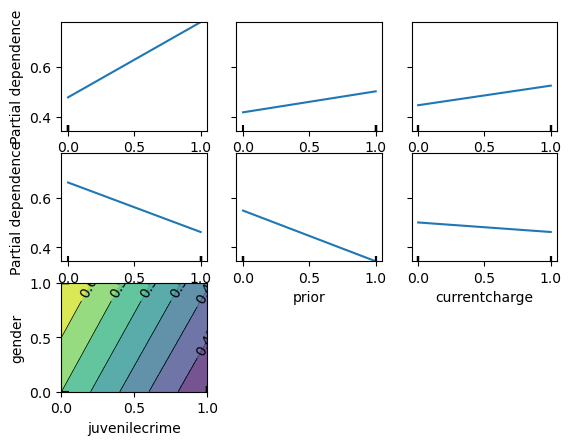

In [28]:
from sklearn.inspection import PartialDependenceDisplay
disp1 = PartialDependenceDisplay.from_estimator(clf, X_train,[0,1,2,3,4,5, (3, 1)])

In [19]:
from itertools import combinations, product

def find_all_pairs(vlist):
    interaction_2_list = []
    for i in combinations(vlist,2):
        interaction_2_list.append(i)
    return interaction_2_list

def FI_two(F1, F2):
    loss = []
    for i in product(VT_l[F1], VT_l[F2]):
        X0 = X_test.copy()
        X0[F1] = X0[F1]*i[0]
        X0[F2] = X0[F2]*i[1]
        loss.append(totalloss(beta_clf, X0, y_test)-bound)
    return loss

In [20]:
VT_l = {}
for i in range(len(vlist)):
    VT_l[vlist[i]] = VT[i]
loss = FI_two('age', 'prior')
loss

[2.49640875437085e+01,
 39.74322324017635,
 47.682171613020955,
 22.248272927439757]

In [29]:
np.corrcoef(h, h_FI)[0,1]

/home/sichao/anaconda3/envs/work_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/sichao/anaconda3/envs/work_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.5941900893973171

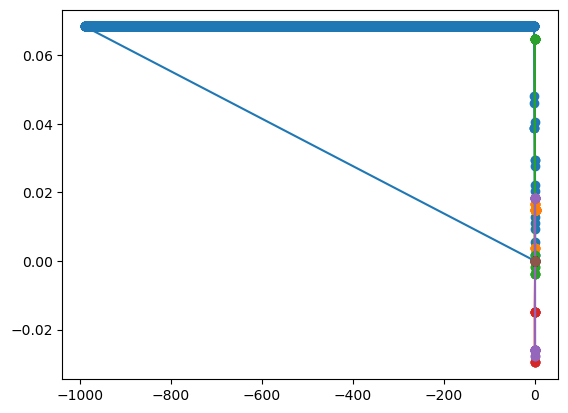

In [51]:
for i in points_all:
    i=np.array(i)
    plt.plot(i[:,0],i[:,1], '-o')

In [135]:
points_all_min[0]+points_all_max[0]

[[0.9, 3231.948496443279],
 [0.8, 3232.726812702259],
 [0.7000000000000001, 3234.0618505142666],
 [0.6000000000000001, 3235.982180396443],
 [0.5000000000000001, 3238.5137372109057],
 [0.40000000000000013, 3241.679406776302],
 [0.30000000000000016, 3245.4986885671215],
 [0.20000000000000015, 3249.9874369167946],
 [0.10000000000000014, 3255.157676525295],
 [1.3877787807814457e-16, 3261.0174832892117],
 [-0.09999999999999987, 3267.5709192692298],
 [-0.19999999999999987, 3274.818011221261],
 [-0.2999999999999999, 3282.7547652226503],
 [-0.3999999999999999, 3291.3732147132955],
 [-0.4999999999999999, 3300.66150459541],
 [-0.5999999999999999, 3310.604018624639],
 [-0.6999999999999998, 3321.1815600307464],
 [-0.7999999999999998, 3332.371595337683],
 [-0.8999999999999998, 3344.1485684612944],
 [-0.9999999999999998, 3356.48428671982],
 [-1.0999999999999999, 3369.34837333214],
 [-1.2, 3382.7087735995447],
 [-1.21, 3384.070839870472],
 [-1.22, 3385.4375041903695],
 [-1.23, 3386.8087328564625],
 [

In [56]:
vt_f[:,-1,:][0,1] = -10

In [ ]:
h_all_pairs(lr_f, X_f)

In [885]:
import itertools
from sklearn.inspection import partial_dependence

univariate = {}
for i in range(10):
    univariate[i] = partial_dependence(lr_f, X_f, features=[i], kind='average')['average']
    
bivariate = {}
for i, j in itertools.combinations(range(10),2):
    bivariate[(i, j)] = partial_dependence(lr_f, X_f, features=[i, j], kind='average')['average']

h = np.zeros((10, 10))
for i, j in itertools.combinations(range(len(vlist)), 2):
    h[i, j] = np.sum(np.square(bivariate[(i, j)] - univariate[i].reshape(1, -1, 1) - univariate[j].reshape(1, 1, -1) + np.mean(y_f) )) / np.sum(np.square(bivariate[(i, j)] - np.mean(y_f)))
#     h[i, j] = np.sum(np.square(bivariate[(i, j)] - univariate[i].reshape(1, -1, 1) - univariate[j].reshape(1, 1, -1))) / np.sum(np.square(bivariate[(i, j)]))


h    
    

array([[0.        , 0.05932922, 0.00250288, 0.00557254, 0.00393129,
        0.00043678, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00342366, 0.01265354, 0.00376202,
        0.0004032 , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.002725  , 0.00283872,
        0.00901546, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00213017,
        0.00068551, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00234732, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

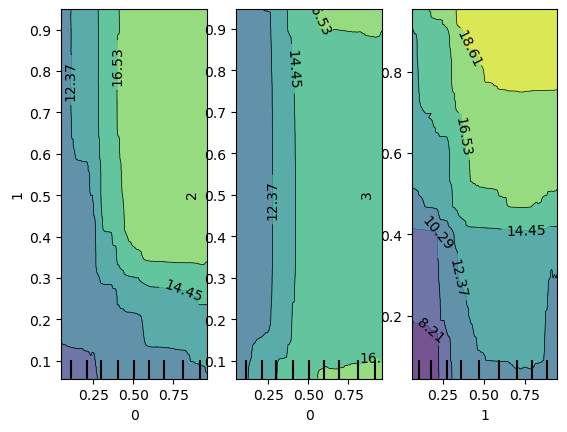

In [884]:
plot_partial_dependence(lr_f, X_f, [(0, 1), (0, 2), (1, 3)])

In [883]:
def FI_two(F1, F2, model):
    loss = []
    for i in product(VT_l_f[F1], VT_l_f[F2]):
        X0 = X_f_minmax.copy()
        X0[:,F1] = X0[:,F1]*i[0]
        X0[:,F2] = X0[:,F2]*i[1]
        pred = model.predict(X0)
        myloss = mean_squared_error(y_f, pred, squared=True)
        loss.append((myloss-bound_f))

#         loss.append(0.25*np.pi*np.square(myloss)-0.25*bound_f*bound_f)
        
    return loss


VT_l_f = {}
for i in range(len(X_f_minmax[-1])):
    VT_l_f[i] = vt_f[i]
pair_l = find_all_pairs(range(10))
h_FI = np.zeros((len(X_f_minmax[-1]), len(X_f_minmax[-1])))
for pair in pair_l:
    FI = FI_two(pair[0], pair[-1], lr_f)
#     print(pair, FI)
#     h_FI[i,j] = np.sum([i**2 for i in FI])/((0.05*loss0)*(0.05*loss0))
    print(FI)
    fi = np.sum((FI))
    h_FI[pair[0], pair[-1]] = fi
h_FI

[0.03439848770637344, 0.013771917575208459, 0.004766801903487883, 0.11836418572035301]
[0.026733109751486683, 0.3388006691559151, 0.002067828679952921, 0.39748869330325487]
[0.025272226650723706, 0.08978399294567385, 0.018145336852220417, 0.19085540292807246]
[0.019245532578893387, 0.18418366271289166, 0.02101240101088675, 0.29024833405804706]
[0.001681853648477949, 0.02812863670076382, 0.049519452501854966, 0.06966826332125842]
[-0.005711430227705705, 0.08965083451328293, 0.03693232664341228, 0.11331931932189843]
[-0.011713014643063957, 0.04806304124504046, 0.04618266789766734, 0.07862231573844536]
[-0.005970192764461979, 0.028235773113727936, 0.04658725287999155, 0.06034013207515487]
[0.004531596482280964, 0.04037078653022652, 0.034405237618529094, 0.08608302328872597]
[0.014070297326203018, 0.34489755895527696, 0.02034516109848905, 0.3949514525064117]
[0.022832551698485748, 0.1023927409675991, 0.013734973670524342, 0.18135326392832551]
[0.019231432387595948, 0.18886472832946444, 0.0

array([[0.        , 0.17130139, 0.7650903 , 0.32405696, 0.51468993,
        0.14899821, 0.23419105, 0.16115501, 0.12919297, 0.16539064],
       [0.        , 0.        , 0.77426447, 0.32031353, 0.51713249,
        0.15950829, 0.24222855, 0.16665928, 0.10302817, 0.15969638],
       [0.        , 0.        , 0.        , 0.94088425, 1.15529763,
        0.83236609, 0.85732322, 0.81960118, 0.73564985, 0.80670655],
       [0.        , 0.        , 0.        , 0.        , 0.70823091,
        0.31506041, 0.43001556, 0.36055504, 0.2881884 , 0.33843964],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.51992356, 0.60827885, 0.53599954, 0.50458689, 0.55789893],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.23452086, 0.17059729, 0.11041315, 0.16607589],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.24836639, 0.18599731, 0.2584594 ],
       [0.        , 0.        , 0.       

In [887]:
def findMax(vname, bound, model, X_test, y_test):
    lr = 0.1
    vt = 1
    count = 1
    points = []
    loss_temp = 0
    loss_count = 0
    while count <= 4:
        X0 = X_test.copy()
        X0[:,vname] = X0[:,vname]*(vt+lr)
#         myloss_user = totalloss(beta_lr, X0, y_test)
        pred = model.predict(X0)
        myloss=mean_squared_error(y_f, pred)
    
        if myloss < bound:
            vt=vt+lr
            points.append([vt, myloss])
            if loss_temp == myloss:
                loss_count = loss_count+1
                if loss_count > 10000:
                    break
            else:
                loss_temp = myloss
        else:
            lr=lr*0.1
            count = count+1
    return vt, points

def findMin(vname, bound, model, X_test, y_test):
    lr = 0.1
    vt = 1
    count = 1
    points = []
    loss_temp = 0
    loss_count = 0
    while count <= 4:
        X0 = X_test.copy()
        X0[:,vname] = X0[:,vname]*(vt+lr)
#         pred = model.predict(sm.add_constant(X0))
#         myloss=log_loss(y_train, pred)
        pred = model.predict(X0)
        myloss=mean_squared_error(y_f, pred)
        print(myloss, vt)
        if myloss < bound:
            vt=vt-lr
            points.append([vt, myloss])
            if loss_temp == myloss:
                loss_count = loss_count+1
                if loss_count > 10000:
                    break
            else:
                loss_temp = myloss
        else:
            lr=lr*0.1
            count = count+1
    return vt, points

def find_VT(bound, vlist, model, X, y):
    VT = np.zeros([len(vlist), 2])
    i = 0
    points_all_max = []
    points_all_min = []

    for vname in range(len(vlist)):
        vt_max, points_max = findMax(vname, bound, model, X, y)
        points_all_max.append(points_max)
        vt_min, points_min = findMin(vname, bound, model, X, y)
        points_all_min.append(points_min)
        VT[i,0] = vt_max
        VT[i,1] = vt_min
        i = i+1
        
    return VT
